Requirements:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [3]:
print(data.DESCR.split('\n')[0:10])
print("Classes:", data.target_names)

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

['.. _breast_cancer_dataset:', '', 'Breast cancer wisconsin (diagnostic) dataset', '--------------------------------------------', '', '**Data Set Characteristics:**', '', ':Number of Instances: 569', '', ':Number of Attributes: 30 numeric, predictive attributes and the class']
Classes: ['malignant' 'benign']
Features shape: (569, 30)
Target distribution:
 1    357
0    212
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
svc_linear = SVC(kernel='linear', C=1.0)
svc_linear.fit(X_train_scaled, y_train)

svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svc_rbf.fit(X_train_scaled, y_train)

SVC()

In [6]:
def evaluate_model(model, X_test, y_test, title=""):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{title} Accuracy: {acc:.4f}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))

evaluate_model(svc_linear, X_test_scaled, y_test, "Linear SVM")
evaluate_model(svc_rbf, X_test_scaled, y_test, "RBF SVM")

Linear SVM Accuracy: 0.9561
[[41  2]
 [ 3 68]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

RBF SVM Accuracy: 0.9825
[[41  2]
 [ 0 71]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [7]:

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


svc_lin_2d = SVC(kernel='linear', C=1.0).fit(X_train_pca, y_train)
svc_rbf_2d = SVC(kernel='rbf', C=1.0, gamma='scale').fit(X_train_pca, y_train)

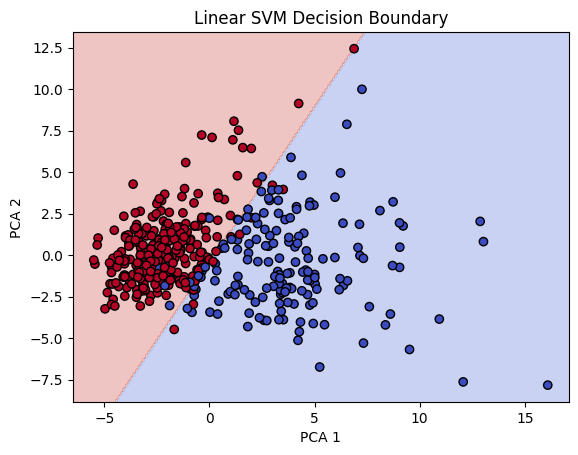

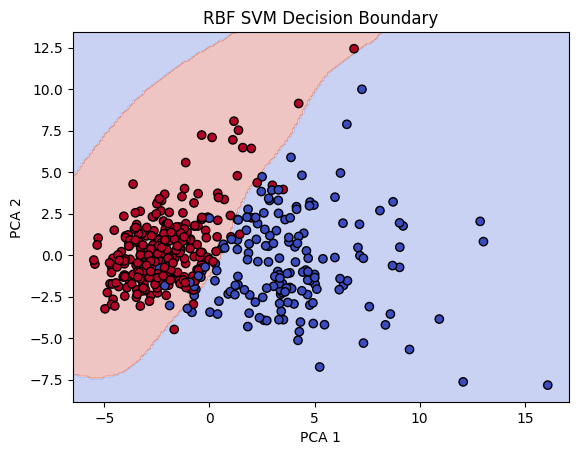

In [8]:
def plot_decision_boundary(model, X, y, title=""):
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

plot_decision_boundary(svc_lin_2d, X_train_pca, y_train, "Linear SVM Decision Boundary")
plot_decision_boundary(svc_rbf_2d, X_train_pca, y_train, "RBF SVM Decision Boundary")

In [9]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=1)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
evaluate_model(grid.best_estimator_, X_test_scaled, y_test, "Tuned RBF SVM")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Tuned RBF SVM Accuracy: 0.9825
[[41  2]
 [ 0 71]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [10]:
linear_score = cross_val_score(svc_linear, X_train_scaled, y_train, cv=5).mean()
rbf_score = cross_val_score(svc_rbf, X_train_scaled, y_train, cv=5).mean()
tuned_score = cross_val_score(grid.best_estimator_, X_train_scaled, y_train, cv=5).mean()

print(f"Linear SVM CV Accuracy: {linear_score:.4f}")
print(f"RBF SVM CV Accuracy: {rbf_score:.4f}")
print(f"Tuned RBF SVM CV Accuracy: {tuned_score:.4f}")

Linear SVM CV Accuracy: 0.9692
RBF SVM CV Accuracy: 0.9758
Tuned RBF SVM CV Accuracy: 0.9758
